In [1]:
import sys
root_dir = !cd .. &&pwd
root_dir = root_dir[0] + "/"
sys.path.insert(0, root_dir)
print(root_dir)

import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import time

from data.tinyimagenet import TinyImageNet

from our_modules.eval_tools import load_and_eval_mls_osr
from our_modules.eval_tools import load_and_eval_mls_osr_for_all_eps


from our_modules.plot_tools import plot_roc
from our_modules.plot_tools import plot_image_on_ax
from our_modules.plot_tools import plot_image
from our_modules.plot_tools import EpsExperimentPlot
from our_modules.plot_tools import IdOodPlot
from our_modules.plot_tools import plot_diff_stats_for_eps
from our_modules.plot_tools import plot_adv_imgs
from our_modules.plot_tools import plot_ranked_scores

from our_modules.tin_tools import test_transform as tin_test_transform
from our_modules.tin_tools import mean as tin_mean, std as tin_std
from our_modules.tin_tools import get_model_for_split
from our_modules.tin_tools import transform_range as tin_clip_range
from our_modules.tin_tools import perturb_tin_image

from our_modules.adv_tools import fn_osr_fgsm, fp_osr_fgsm, fn_osr_fgsm_log_msp
from our_modules.adv_tools import iterative_attack, fn_osr_itat, fp_osr_itat, fp_osr_itat_sum_exp
from our_modules.adv_tools import norm_loss, sum_exp_loss

if sys.platform == 'darwin':
    device = torch.device("mps")
else:
    gpu = torch.cuda.is_available()
    device = torch.device("cuda:0" if gpu else "cpu")

print("device:", device)

tin_dataset = TinyImageNet(root_dir + 'datasets/tiny-imagenet-200/val/images/', transform=tin_test_transform)
idx_goldfish, idx_panda = 9, 2915
tin_goldfish = tin_dataset[idx_goldfish][0] # Novel in split 0
tin_panda = tin_dataset[idx_panda][0] # Familiar in split 0
tin_grad_norm_dir = root_dir + 'grad_norms/tinyimagenet/'
tin_logits_dir = root_dir + "logits/tinyimagenet/"
path_to_pretrained_weights_folder = root_dir + 'pretrained_weights/'
vis_log = root_dir + 'visualizations/'
file_name_list = []

/Users/gunder/Desktop/bachelor_project/
device: mps


## Adv attack

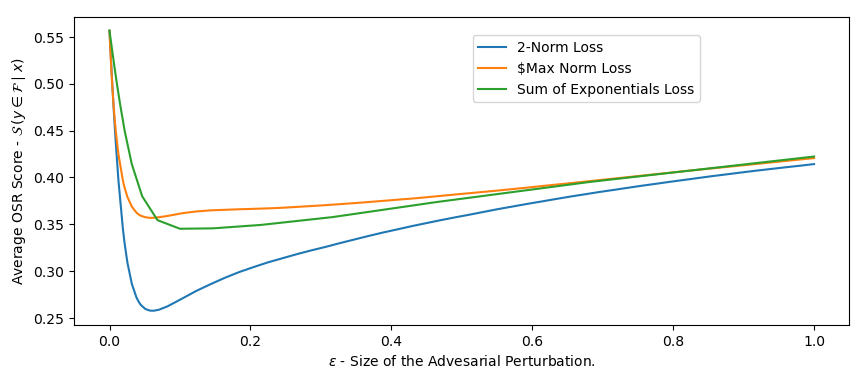

In [2]:
# FP attack comparison
file_name = 'mls_comp_fgsm_fp'
file_name_list.append(file_name)
comparison_exp_2 = EpsExperimentPlot(which_lines='mls', add_zoom=False)
comparison_exp_2.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fp/fgsm/two_norm/', 0, True, label_suffix='2-Norm Loss', max_eps=1.001)
comparison_exp_2.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fp/fgsm/max/', 0, True, label_suffix= '$Max Norm Loss', max_eps=1.001)
comparison_exp_2.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fp/fgsm/sum_exp/', 0, True, label_suffix= 'Sum of Exponentials Loss', max_eps=1.001)
comparison_exp_2.set_legend_and_highlight_eps(legend_loc=(0.55, 0.73))
comparison_exp_2.show_and_save(vis_log + file_name)

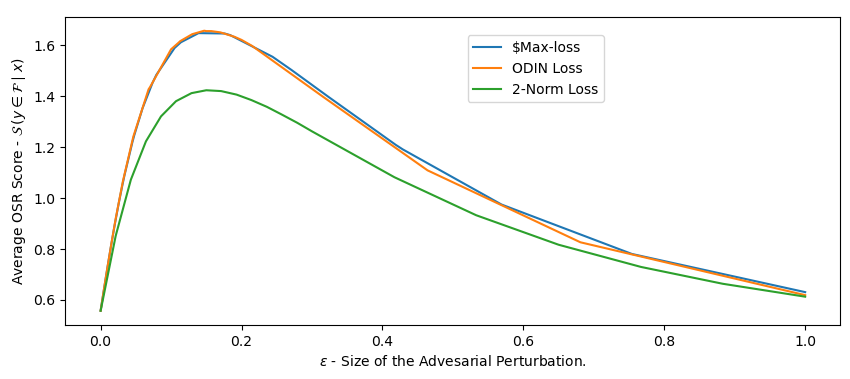

In [3]:
file_name = 'mls_comp_fgsm_fn'
file_name_list.append(file_name)
comparison_exp_2 = EpsExperimentPlot(which_lines='mls', add_zoom=False)
max_eps = 1.001
comparison_exp_2.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fn/fgsm/max/', 0, True, label_suffix='$Max-loss', max_eps = max_eps)
comparison_exp_2.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fn/fgsm/log_msp/', 0, True, label_suffix= 'ODIN Loss', max_eps = max_eps)
comparison_exp_2.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fn/fgsm/two_norm/', 0, True, label_suffix= '2-Norm Loss', max_eps = max_eps)
comparison_exp_2.set_legend_and_highlight_eps(legend_loc=(0.55, 0.73))
comparison_exp_2.show_and_save(vis_log + file_name)

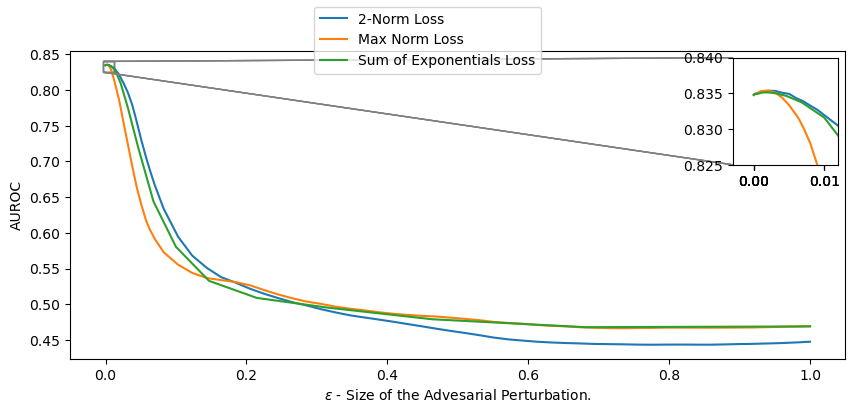

In [4]:
file_name = 'auroc_comp_fgsm_fp'
file_name_list.append(file_name)
comparison_exp_1 = EpsExperimentPlot(which_lines='AUROC')
max_eps = 1.01
# comparison_exp_1.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fn/fgsm/max/', 0, True, label_suffix=' ; FN with Max norm', max_eps=max_eps)
# comparison_exp_1.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fn/fgsm/log_msp/', 0, True, label_suffix= ' ; FN with ODIN Loss', max_eps=max_eps)
# comparison_exp_1.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fn/fgsm/sum_exp/', 0, True, label_suffix= ' ; FN with sum of exp loss', max_eps=max_eps)
comparison_exp_1.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fp/fgsm/two_norm/', 0, True, label_suffix='2-Norm Loss', max_eps=max_eps)
comparison_exp_1.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fp/fgsm/max/', 0, True, label_suffix= 'Max Norm Loss', max_eps=max_eps)
comparison_exp_1.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fp/fgsm/sum_exp/', 0, True, label_suffix= 'Sum of Exponentials Loss', max_eps=max_eps)
comparison_exp_1.set_legend_and_highlight_eps(legend_loc='upper center')
comparison_exp_1.show_and_save(vis_log + file_name)

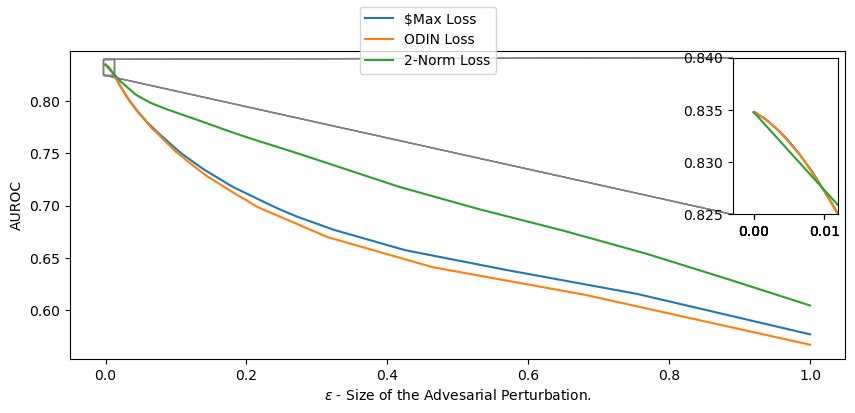

In [5]:
file_name = 'auroc_comp_fgsm_fn'
file_name_list.append(file_name)
comparison_exp_1 = EpsExperimentPlot(which_lines='AUROC')
max_eps = 1.0001
comparison_exp_1.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fn/fgsm/max/', 0, True, label_suffix='$Max Loss', max_eps=max_eps)
comparison_exp_1.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fn/fgsm/log_msp/', 0, True, label_suffix= 'ODIN Loss', max_eps=max_eps)
comparison_exp_1.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fn/fgsm/two_norm/', 0, True, label_suffix='2-Norm Loss', max_eps=max_eps)
# comparison_exp_1.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fn/fgsm/sum_exp/', 0, True, label_suffix= ' ; FN with sum of exp loss', max_eps=max_eps)
# comparison_exp_1.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fp/fgsm/two_norm/', 0, True, label_suffix=' ; FP with 2-norm', max_eps=max_eps)
# comparison_exp_1.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fp/fgsm/max/', 0, True, label_suffix= ' ; FP with Max norm', max_eps=max_eps)
# comparison_exp_1.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fp/fgsm/sum_exp/', 0, True, label_suffix= ' ; FP with sum of exp loss', max_eps=max_eps)
comparison_exp_1.set_legend_and_highlight_eps(legend_loc='upper center')
comparison_exp_1.show_and_save(vis_log + file_name)

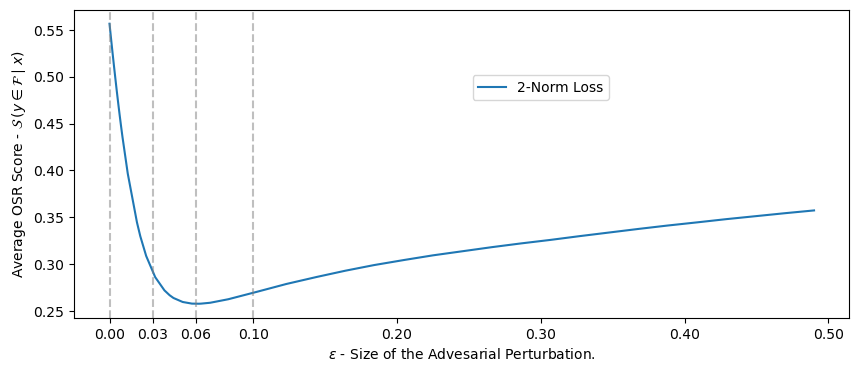

/Users/gunder/Desktop/bachelor_project/our_modules/adv_tools.py:8: UserWarning: The operator 'aten::linalg_vector_norm' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1670525498485/work/aten/src/ATen/mps/MPSFallback.mm:11.)
  return torch.linalg.norm(y_hat, **norm_kwargs)


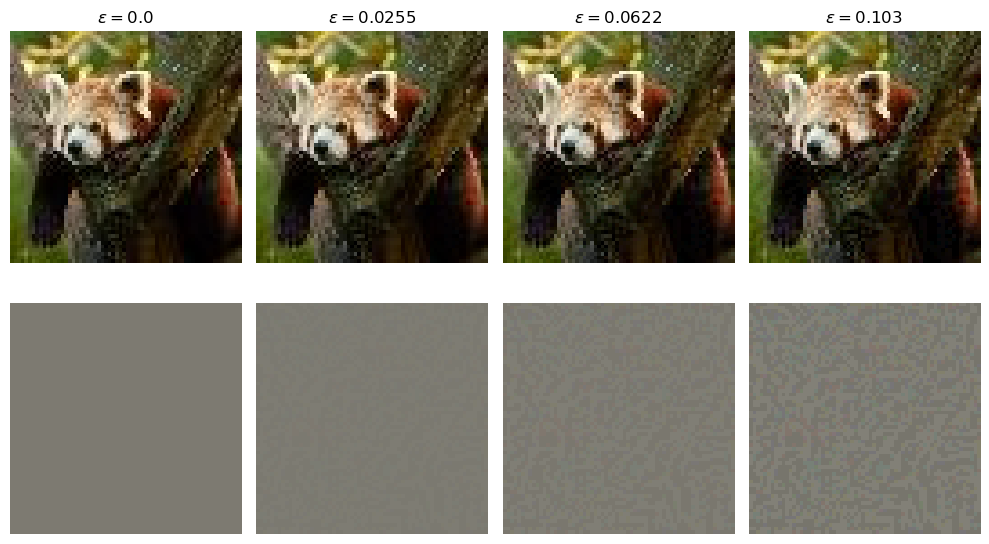

In [6]:
file_name = 'vis_pertubation_fgsm_fp_'
file_name_list.append(file_name)
comparison_exp_2 = EpsExperimentPlot(which_lines='mls', add_zoom=False)
highlight_eps_idx = [0,16,23, 27]
comparison_exp_2.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fp/fgsm/two_norm/', 0, True, label_suffix='2-Norm Loss', max_eps=0.501)
comparison_exp_2.set_legend_and_highlight_eps(eps_idxs=highlight_eps_idx,legend_loc=(0.55, 0.73))
comparison_exp_2.show_and_save(vis_log + file_name + 'graph')
highlight_eps = comparison_exp_2.recent_eps[highlight_eps_idx]
plot_adv_imgs(highlight_eps, *perturb_tin_image(highlight_eps, tin_panda, path_to_pretrained_weights_folder, device, split_num=0, 
                                                                      attack=fn_osr_fgsm, norm_ord=torch.inf),
              mean=tin_mean, std=tin_std, figsize=(10,6), save_path = vis_log + file_name + 'img')

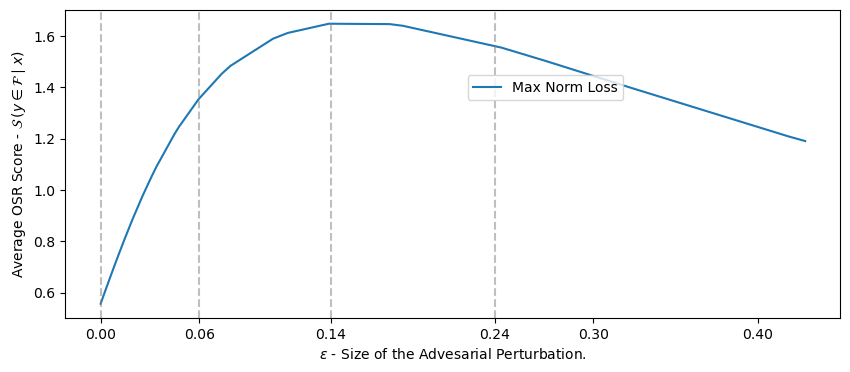

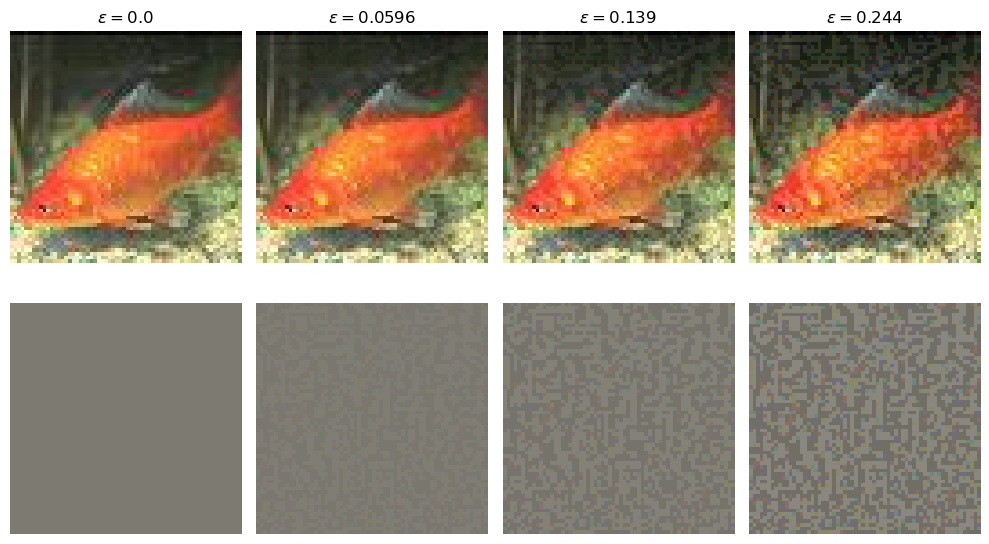

In [7]:
file_name = 'vis_pertubation_fgsm_fn_'
file_name_list.append(file_name)
comparison_exp_2 = EpsExperimentPlot(which_lines='mls', add_zoom=False)
highlight_eps_idx = [0,43,48,51]
comparison_exp_2.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fn/fgsm/max/', 0, True, label_suffix='Max Norm Loss', max_eps=0.501)
comparison_exp_2.set_legend_and_highlight_eps(eps_idxs=highlight_eps_idx,legend_loc=(0.55, 0.73))
comparison_exp_2.show_and_save(vis_log + file_name + 'graph')
highlight_eps = comparison_exp_2.recent_eps[highlight_eps_idx]
plot_adv_imgs(highlight_eps, *perturb_tin_image(highlight_eps, tin_goldfish, path_to_pretrained_weights_folder, device, split_num=0, 
                                                                      attack=fn_osr_fgsm, norm_ord=torch.inf),
              mean=tin_mean, std=tin_std, figsize=(10,6), save_path=vis_log + file_name + 'img')

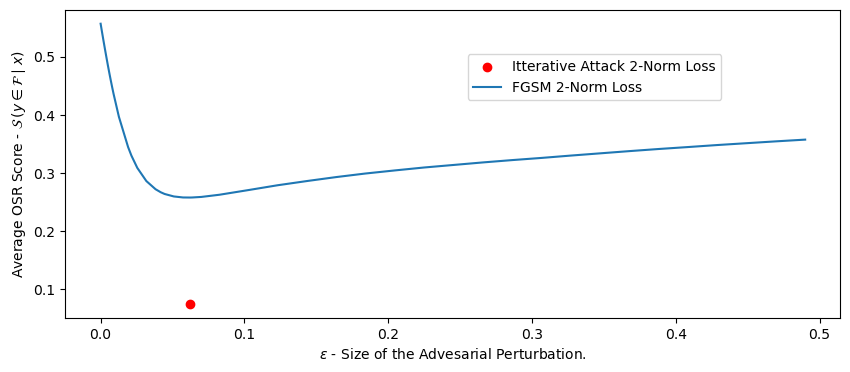

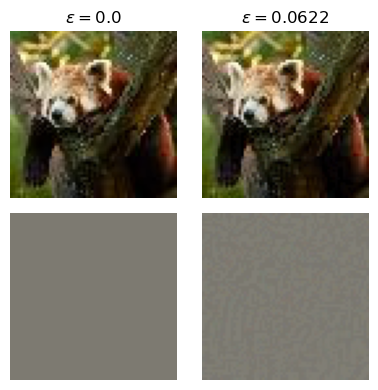

In [8]:
file_name = 'fgsm_v_itat_fp_'
file_name_list.append(file_name)
comparison_exp_2 = EpsExperimentPlot(which_lines='mls', add_zoom=False)
mean_itat = torch.mean(torch.amax(torch.load(tin_logits_dir+ 'fp/itat/two_norm/eps_0.0622/logits_0.pt'), dim=-1))
highlight_eps_idx = []
comparison_exp_2.ax1.scatter([0.0622],[mean_itat], label='Itterative Attack 2-Norm Loss', c='red')
comparison_exp_2.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fp/fgsm/two_norm/', 0, True, label_suffix='FGSM 2-Norm Loss', max_eps=0.501)
comparison_exp_2.set_legend_and_highlight_eps(eps_idxs=highlight_eps_idx,legend_loc=(0.55, 0.73))
comparison_exp_2.show_and_save(vis_log + file_name + 'graph')
highlight_eps = comparison_exp_2.recent_eps[highlight_eps_idx]
these_eps = [0.0, 0.0622]
plot_adv_imgs(these_eps, 
              *perturb_tin_image(these_eps, tin_panda, path_to_pretrained_weights_folder, device, split_num=0, attack=fp_osr_itat, norm_ord=None, max_iter=25, step_sizes=(1e-06, 1)),
              mean=tin_mean, std=tin_std, figsize=(4,4), save_path=vis_log + file_name + 'img')

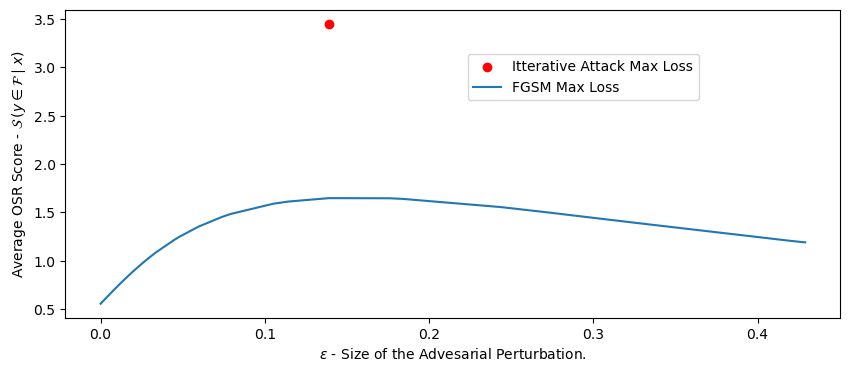

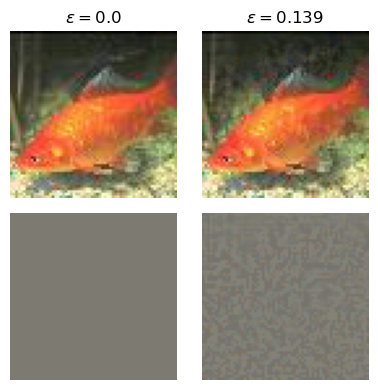

In [9]:
file_name = 'fgsm_v_itat_fn_'
file_name_list.append(file_name)
comparison_exp_2 = EpsExperimentPlot(which_lines='mls', add_zoom=False)
mean_itat = torch.mean(torch.amax(torch.load(tin_logits_dir+ 'fn/itat/max/eps_0.139/logits_0.pt'), dim=-1))
highlight_eps_idx = []
comparison_exp_2.ax1.scatter([0.139],[mean_itat], label='Itterative Attack Max Loss', c='red')
comparison_exp_2.load_and_add_mls_to_eps_plot(root_dir + 'logits/tinyimagenet/fn/fgsm/max/', 0, True, label_suffix='FGSM Max Loss', max_eps=0.501)
comparison_exp_2.set_legend_and_highlight_eps(eps_idxs=highlight_eps_idx,legend_loc=(0.55, 0.73))
comparison_exp_2.show_and_save(vis_log + file_name + 'graph')
highlight_eps = comparison_exp_2.recent_eps[highlight_eps_idx]
these_eps = [0.0, 0.139]
plot_adv_imgs(these_eps, 
              *perturb_tin_image(these_eps, tin_goldfish, path_to_pretrained_weights_folder, device, split_num=0, attack=fn_osr_itat, norm_ord=None, max_iter=25, step_sizes=(1e-06, 1)),
              mean=tin_mean, std=tin_std, figsize=(4,4), save_path = vis_log + file_name + 'img')

In [10]:
roc_stats_plain = load_and_eval_mls_osr(root_dir + "logits/tinyimagenet/plain/logits_0.pt", root_dir + "logits/tinyimagenet/plain/csr_targets_0.pt",
                      0, dataset_name='tinyimagenet', balance=True)
# roc_stats_fp, _ = load_and_eval_mls_osr(root_dir + "logits/tinyimagenet/fgsm_fp_attack/logits_split_0.pt", root_dir + "logits/tinyimagenet/plain/csr_targets_split_0.pt",
#                                       0, dataset_name='tinyimagenet')
roc_stats_exp1 = load_and_eval_mls_osr(root_dir + "logits/tinyimagenet/informed/fgsm/exp1/logits_0.pt", 
                                        root_dir + "logits/tinyimagenet/informed/fgsm/exp1/csr_targets_0.pt",
                                        0, dataset_name='tinyimagenet', balance=True)
roc_stats_exp2 = load_and_eval_mls_osr(root_dir + "logits/tinyimagenet/informed/fgsm/exp2/logits_0.pt", 
                                        root_dir + "logits/tinyimagenet/informed/fgsm/exp2/csr_targets_0.pt",
                                        0, dataset_name='tinyimagenet', balance=True)
roc_stats_exp3 = load_and_eval_mls_osr(root_dir + "logits/tinyimagenet/informed/fgsm/exp3/logits_0.pt", 
                                        root_dir + "logits/tinyimagenet/informed/fgsm/exp3/csr_targets_0.pt",
                                        0, dataset_name='tinyimagenet', balance=True)

roc_stats_exp1_itat = load_and_eval_mls_osr(root_dir + "logits/tinyimagenet/informed/itat/exp1/logits_0.pt", 
                                        root_dir + "logits/tinyimagenet/informed/itat/exp1/csr_targets_0.pt",
                                        0, dataset_name='tinyimagenet', balance=True)
roc_stats_exp2_itat = load_and_eval_mls_osr(root_dir + "logits/tinyimagenet/informed/itat/exp2/logits_0.pt", 
                                        root_dir + "logits/tinyimagenet/informed/itat/exp2/csr_targets_0.pt",
                                        0, dataset_name='tinyimagenet', balance=True)
roc_stats_exp3_itat = load_and_eval_mls_osr(root_dir + "logits/tinyimagenet/informed/itat/exp3/logits_0.pt", 
                                        root_dir + "logits/tinyimagenet/informed/itat/exp3/csr_targets_0.pt",
                                        0, dataset_name='tinyimagenet', balance=True)


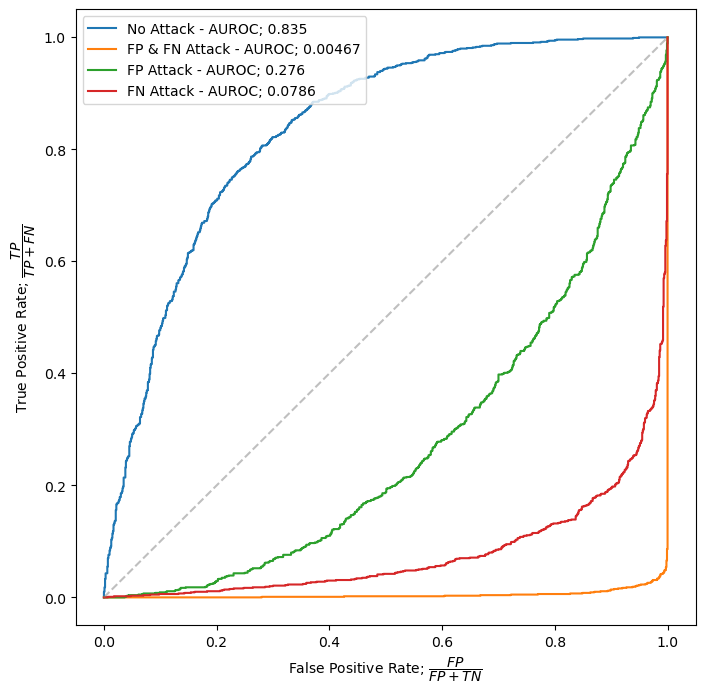

In [11]:
file_name = 'roc_fgsm'
file_name_list.append(file_name)
fig, ax = plt.subplots(1,1,figsize=(8,8))
plot_roc(ax, roc_stats_plain[0], label=f'No Attack - AUROC; {roc_stats_plain[1]:.3}')
# plot_roc(ax, roc_stats_fp, label="FP attack")
plot_roc(ax, roc_stats_exp1[0], label=f'FP & FN Attack - AUROC; {roc_stats_exp1[1]:.3}')
plot_roc(ax, roc_stats_exp2[0], label=f'FP Attack - AUROC; {roc_stats_exp2[1]:.3}')
plot_roc(ax, roc_stats_exp3[0], label=f'FN Attack - AUROC; {roc_stats_exp3[1]:.3}')
# plot_roc(ax, roc_stats_exp1_itat[0], label=f'||FP & FN Attack - AUROC; {roc_stats_exp1_itat[1]:.3}')
# plot_roc(ax, roc_stats_exp2_itat[0], label=f'||FP & plain Attack - AUROC; {roc_stats_exp2_itat[1]:.3}')
# plot_roc(ax, roc_stats_exp3_itat[0], label=f'||Plain & FN Attack - AUROC; {roc_stats_exp3_itat[1]:.3}')
ax.plot([0,1],[0,1], linestyle='--', alpha=0.5, c='gray')
ax.set_xlabel("False Positive Rate; $\\dfrac{FP}{FP + TN}$")
ax.set_ylabel("True Positive Rate; $\\dfrac{TP}{TP + FN}$")
plt.legend(loc='upper left')
plt.savefig(vis_log + file_name + '.pdf', bbox_inches='tight')
plt.show()

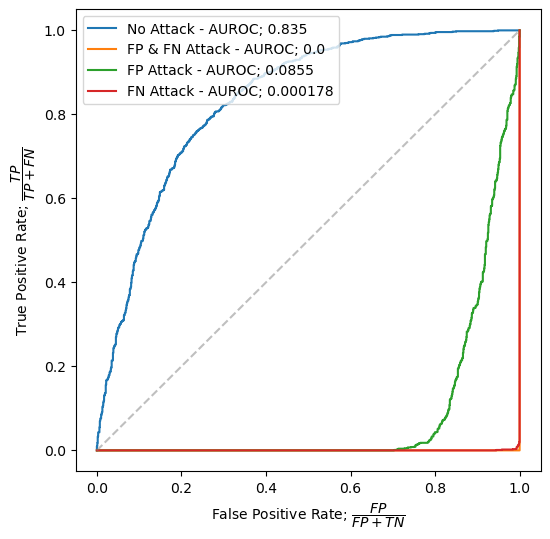

In [12]:
file_name = 'roc_itat'
file_name_list.append(file_name)
fig, ax = plt.subplots(1,1,figsize=(6,6))
plot_roc(ax, roc_stats_plain[0], label=f'No Attack - AUROC; {roc_stats_plain[1]:.3}')
# plot_roc(ax, roc_stats_exp1[0], label=f'FP & FN Attack - AUROC; {roc_stats_exp1[1]:.3}')
# plot_roc(ax, roc_stats_exp2[0], label=f'FP & plain Attack - AUROC; {roc_stats_exp2[1]:.3}')
# plot_roc(ax, roc_stats_exp3[0], label=f'Plain & FN Attack - AUROC; {roc_stats_exp3[1]:.3}')
plot_roc(ax, roc_stats_exp1_itat[0], label=f'FP & FN Attack - AUROC; {roc_stats_exp1_itat[1]:.3}')
plot_roc(ax, roc_stats_exp2_itat[0], label=f'FP Attack - AUROC; {roc_stats_exp2_itat[1]:.3}')
plot_roc(ax, roc_stats_exp3_itat[0], label=f'FN Attack - AUROC; {roc_stats_exp3_itat[1]:.3}')
ax.plot([0,1],[0,1], linestyle='--', alpha=0.5, c='gray')
ax.set_xlabel("False Positive Rate; $\\dfrac{FP}{FP + TN}$")
ax.set_ylabel("True Positive Rate; $\\dfrac{TP}{TP + FN}$")
plt.legend(loc='upper left')
plt.savefig(vis_log + file_name + '.pdf', bbox_inches='tight')
plt.show()

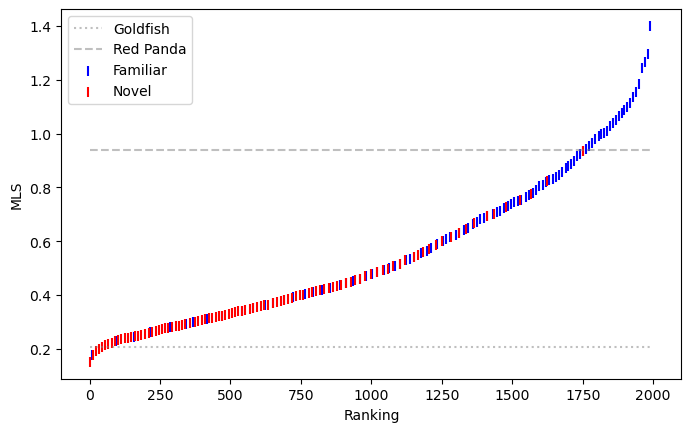

In [13]:
# Plain Ranking
file_name = 'ranking_plain'
file_name_list.append(file_name)
plot_ranked_scores(tin_logits_dir + 'plain/logits_0.pt', path_to_csr_targets=tin_logits_dir + 'plain/csr_targets_0.pt', figsize=(10*0.8, 6*0.8), step=10, s=50, 
                   highlight_idx=[idx_goldfish, idx_panda], highlighted_label=['Goldfish', 'Red Panda'], highlighted_linestyle=['dotted', 'dashed'],
                   save_path = vis_log + file_name)

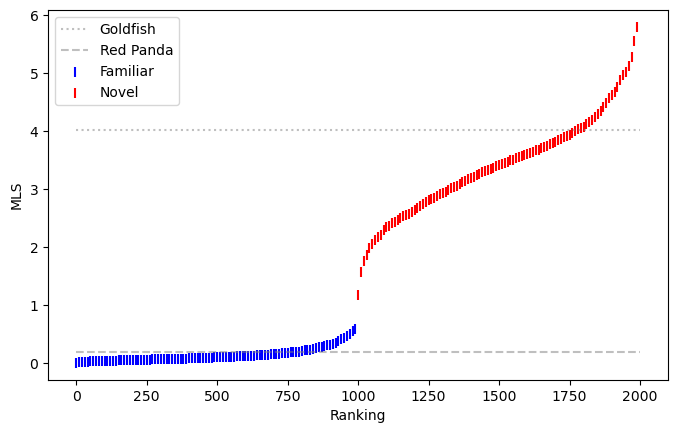

In [14]:
#both 
file_name = 'ranking_both'
file_name_list.append(file_name)
plot_ranked_scores(tin_logits_dir + 'informed/itat/exp1/logits_0.pt', path_to_csr_targets=tin_logits_dir + 'informed/itat/exp1/csr_targets_0.pt', figsize=(10*0.8, 6*0.8), step=10, s=50, ylim=None, 
                   highlight_idx=[idx_goldfish, idx_panda], highlighted_label=['Goldfish', 'Red Panda'], highlighted_linestyle=['dotted', 'dashed'],
                   save_path = vis_log + file_name)

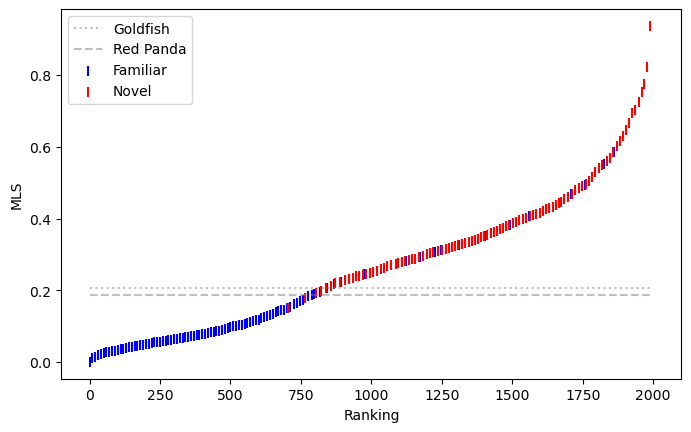

In [15]:
# FP
file_name = 'ranking_fp'
file_name_list.append(file_name)
plot_ranked_scores(tin_logits_dir + 'informed/itat/exp2/logits_0.pt', path_to_csr_targets=tin_logits_dir + 'informed/itat/exp2/csr_targets_0.pt', figsize=(10*0.8, 6*0.8), step=10, s=50, 
                   highlight_idx=[idx_goldfish, idx_panda], highlighted_label=['Goldfish', 'Red Panda'], highlighted_linestyle=['dotted', 'dashed'],
                   save_path = vis_log + file_name)

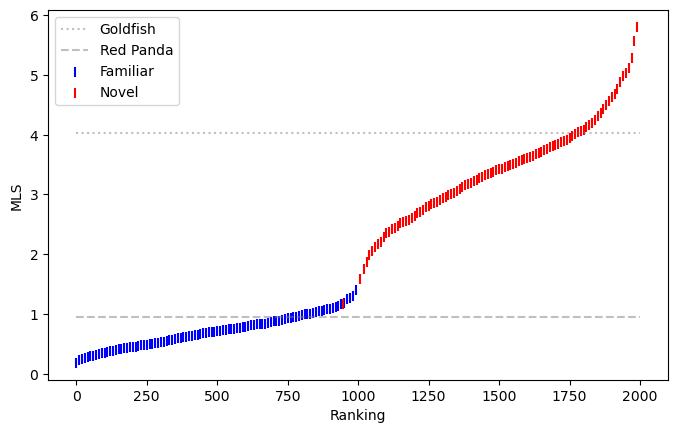

In [16]:
# FN
file_name = 'ranking_fn'
file_name_list.append(file_name)
plot_ranked_scores(tin_logits_dir + 'informed/itat/exp3/logits_0.pt', path_to_csr_targets=tin_logits_dir + 'informed/itat/exp3/csr_targets_0.pt', figsize=(10*0.8, 6*0.8), step=10, s=50, 
                   highlight_idx=[idx_goldfish, idx_panda], highlighted_label=['Goldfish', 'Red Panda'], highlighted_linestyle=['dotted', 'dashed'],
                   save_path = vis_log + file_name)

## Scoring rooles

### start test

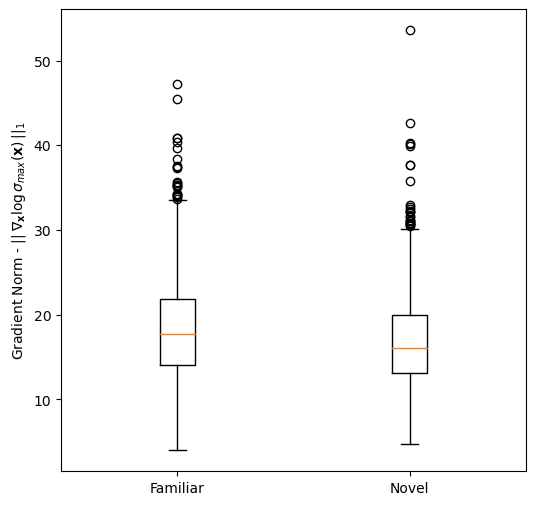

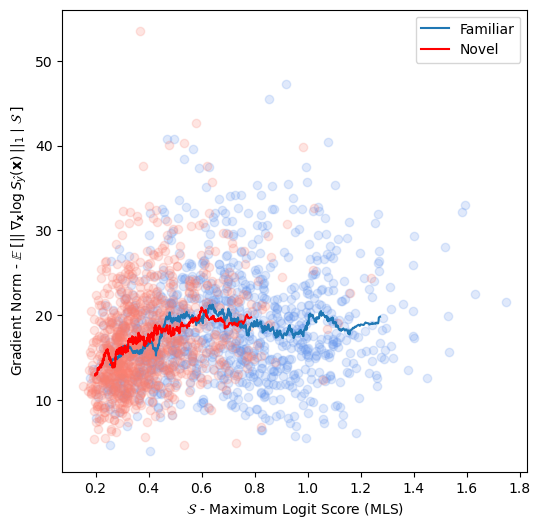

In [17]:
# Gradient Normtest
file_name = 'gradient_norm_'
file_name_list.append(file_name)
scatter_log_msp_grad_norms = IdOodPlot()
scatter_log_msp_grad_norms.load_grad_norm_stats(tin_grad_norm_dir + 'log_msp/', root_dir + 'logits/tinyimagenet/plain/', split_num=0, balance=True)
scatter_log_msp_grad_norms.make_boxplot(labels = ['Familiar', 'Novel'], ylabel=r'Gradient Norm - $||\:\nabla_{\bf{x}} \log \sigma_{max}({\bf{x}}) \:||_1$')
scatter_log_msp_grad_norms.show_and_save(vis_log + file_name + 'box')
scatter_log_msp_grad_norms.make_scatter_plot(window_size=25)
# scatter_log_msp_grad_norms.ax.set_ylabel(r'Gradient Norm - $||\:\nabla_{\bf{x}} \log S_{\hat{y}}({\bf{x}}) \:||_1$')
scatter_log_msp_grad_norms.set_legend()
scatter_log_msp_grad_norms.show_and_save(vis_log + file_name + 'scatter')

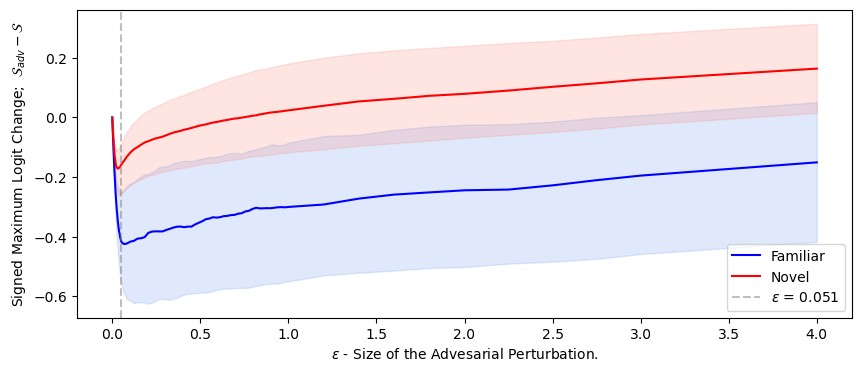

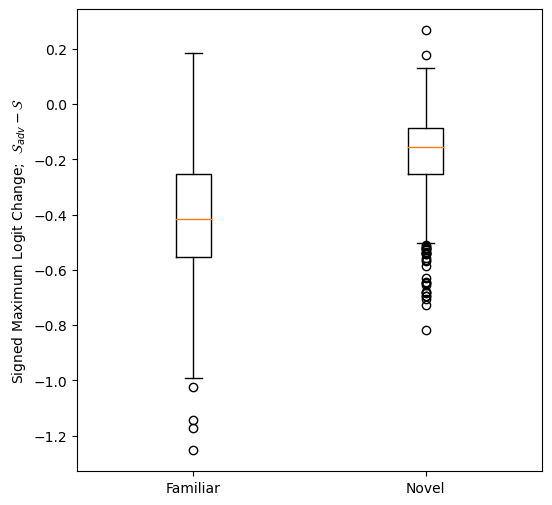

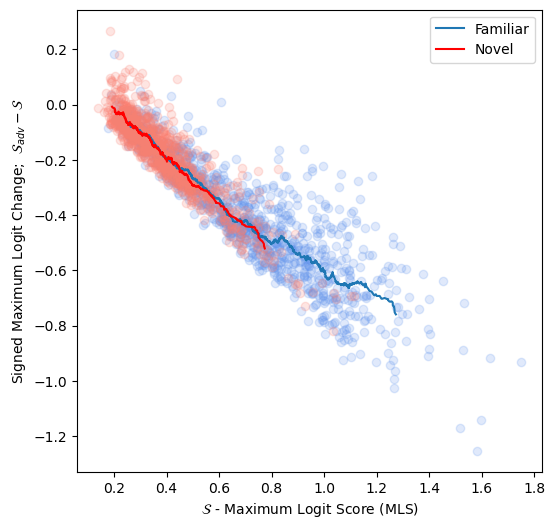

In [18]:
# Best scoring rool adv attack fp two norm 0.0509
file_name = 'scoring_fp_two_norm_'
file_name_list.append(file_name)
plot_diff_stats_for_eps(root_dir + "logits/tinyimagenet/plain/logits_0.pt",
                       root_dir + "logits/tinyimagenet/fp/fgsm/two_norm/",
                       root_dir + "logits/tinyimagenet/plain/csr_targets_0.pt",
                       split_num = 0, 
                       dataset_name='tinyimagenet',
                       figsize=(10,4),
                       highlight_eps_idx=21,
                       save_path=vis_log + file_name + 'all_eps')

scatter_mls_diffs = IdOodPlot()
scatter_mls_diffs.load_mls_diffs_stats(root_dir + "logits/tinyimagenet/plain/logits_0.pt",
                                                root_dir + "logits/tinyimagenet/fp/fgsm/two_norm/eps_0.0509/logits_0.pt",
                                                root_dir + "logits/tinyimagenet/plain/csr_targets_0.pt",
                                                0, dataset_name='tinyimagenet', balance=True)
scatter_mls_diffs.make_boxplot(labels = ['Familiar', 'Novel'], ylabel=r'Signed Maximum Logit Change;  $\mathcal{S}_{adv} - \mathcal{S}$')
scatter_mls_diffs.show_and_save(save_path=vis_log + file_name + 'box')
scatter_mls_diffs.make_scatter_plot(window_size=25, ylabel=r'Signed Maximum Logit Change;  $\mathcal{S}_{adv} - \mathcal{S}$')
scatter_mls_diffs.set_legend()
scatter_mls_diffs.show_and_save(save_path=vis_log + file_name + 'scatter')

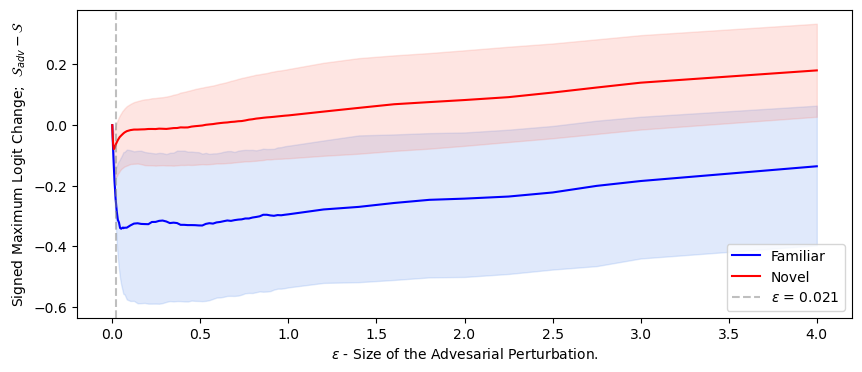

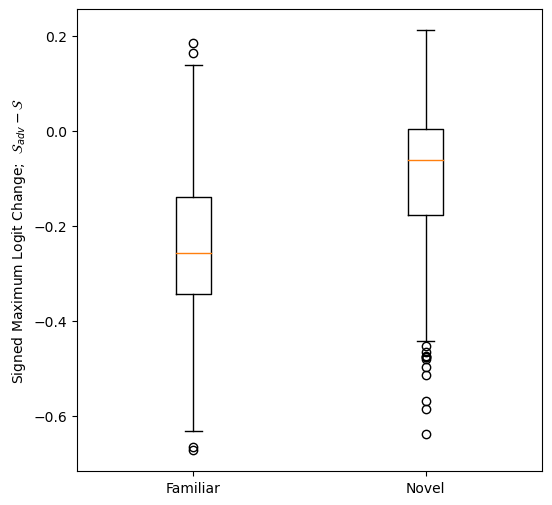

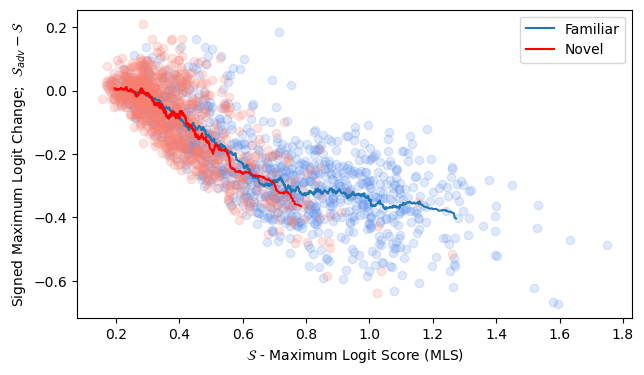

In [19]:
# Other scorring rool. FP Max norm appendix
file_name = 'scoring_fp_max_'
file_name_list.append(file_name)
plot_diff_stats_for_eps(root_dir + "logits/tinyimagenet/plain/logits_0.pt",
                       root_dir + "logits/tinyimagenet/fp/fgsm/max/",
                       root_dir + "logits/tinyimagenet/plain/csr_targets_0.pt",
                       split_num = 0, 
                       dataset_name='tinyimagenet',
                       figsize=(10,4),
                       highlight_eps_idx=15,
                       save_path=vis_log + file_name + 'all_eps')

scatter_mls_diffs = IdOodPlot()
scatter_mls_diffs.load_mls_diffs_stats(root_dir + "logits/tinyimagenet/plain/logits_0.pt",
                                                root_dir + "logits/tinyimagenet/fp/fgsm/max/eps_0.0214/logits_0.pt",
                                                root_dir + "logits/tinyimagenet/plain/csr_targets_0.pt",
                                                0, dataset_name='tinyimagenet', balance=True
                                                ,)
scatter_mls_diffs.make_boxplot(labels = ['Familiar', 'Novel'], ylabel=r'Signed Maximum Logit Change;  $\mathcal{S}_{adv} - \mathcal{S}$')
scatter_mls_diffs.show_and_save(save_path=vis_log + file_name + 'box')
scatter_mls_diffs.make_scatter_plot(figsize=(10,4),window_size=25, ylabel=r'Signed Maximum Logit Change;  $\mathcal{S}_{adv} - \mathcal{S}$')
scatter_mls_diffs.ax.set_aspect('equal')
scatter_mls_diffs.set_legend()
scatter_mls_diffs.show_and_save(save_path= vis_log + file_name + 'scatter')

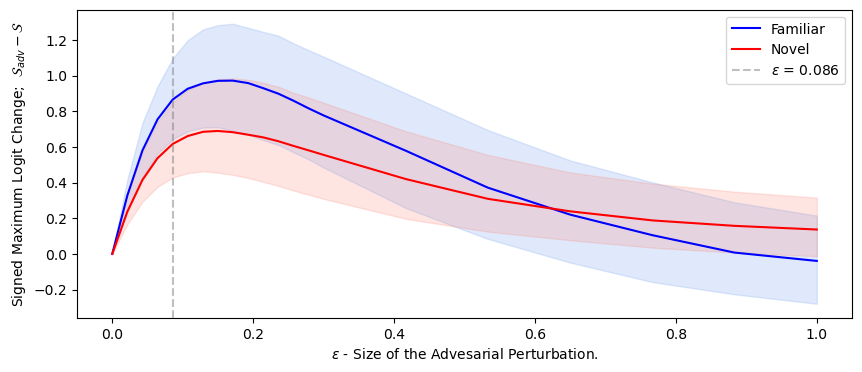

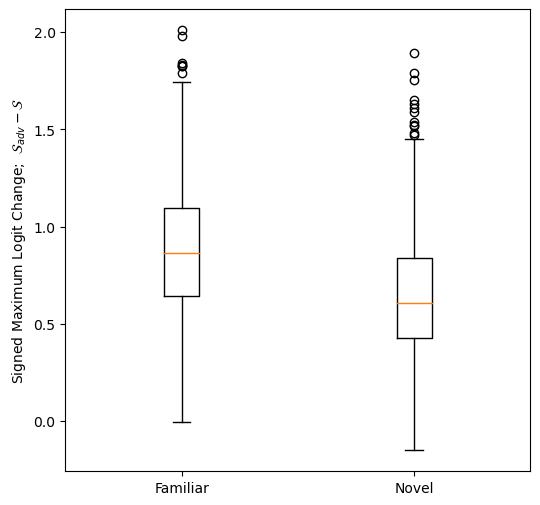

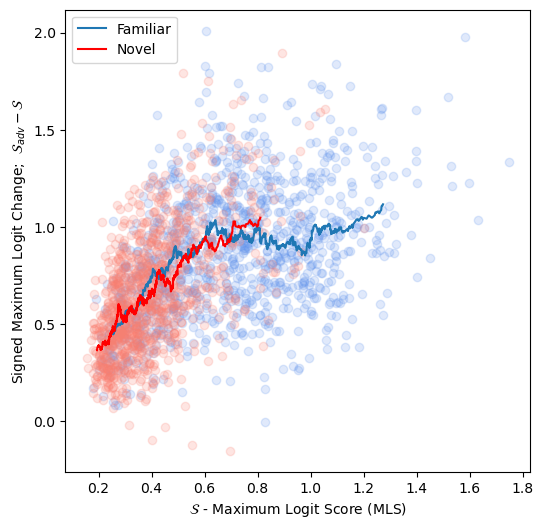

In [20]:
# FN two norm appendix
file_name = 'scoring_fn_two_norm_'
file_name_list.append(file_name)
plot_diff_stats_for_eps(root_dir + "logits/tinyimagenet/plain/logits_0.pt",
                       root_dir + "logits/tinyimagenet/fn/fgsm/two_norm/",
                       root_dir + "logits/tinyimagenet/plain/csr_targets_0.pt",
                       split_num = 0, 
                       dataset_name='tinyimagenet',
                       figsize=(10,4),
                       highlight_eps_idx=4,
                       save_path=vis_log + file_name + 'all_eps')

scatter_mls_diffs = IdOodPlot()
scatter_mls_diffs.load_mls_diffs_stats(root_dir + "logits/tinyimagenet/plain/logits_0.pt",
                                                root_dir + "logits/tinyimagenet/fn/fgsm/two_norm/eps_0.0857/logits_0.pt",
                                                root_dir + "logits/tinyimagenet/plain/csr_targets_0.pt",
                                                0, dataset_name='tinyimagenet', balance=True)
scatter_mls_diffs.make_boxplot(labels = ['Familiar', 'Novel'], ylabel=r'Signed Maximum Logit Change;  $\mathcal{S}_{adv} - \mathcal{S}$')
scatter_mls_diffs.show_and_save(save_path=vis_log + file_name + 'box')
scatter_mls_diffs.make_scatter_plot(window_size=25, ylabel=r'Signed Maximum Logit Change;  $\mathcal{S}_{adv} - \mathcal{S}$')
scatter_mls_diffs.set_legend()
scatter_mls_diffs.show_and_save(save_path=vis_log + file_name + 'scatter')

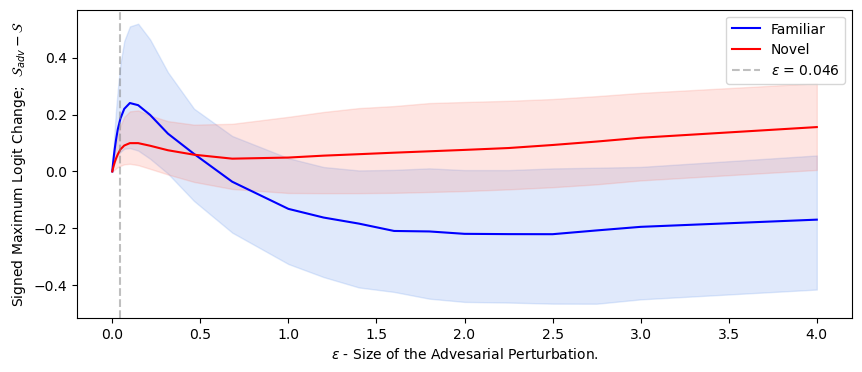

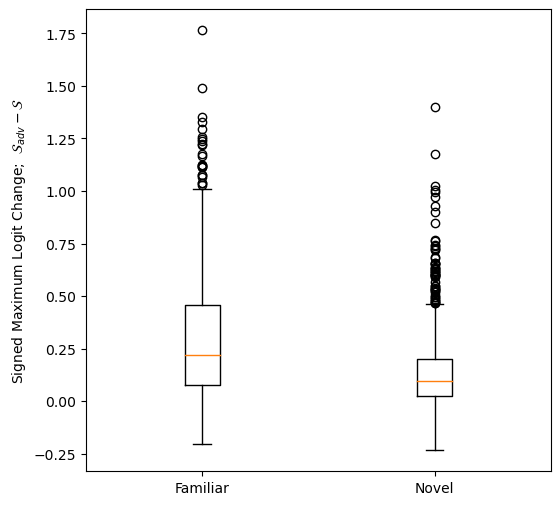

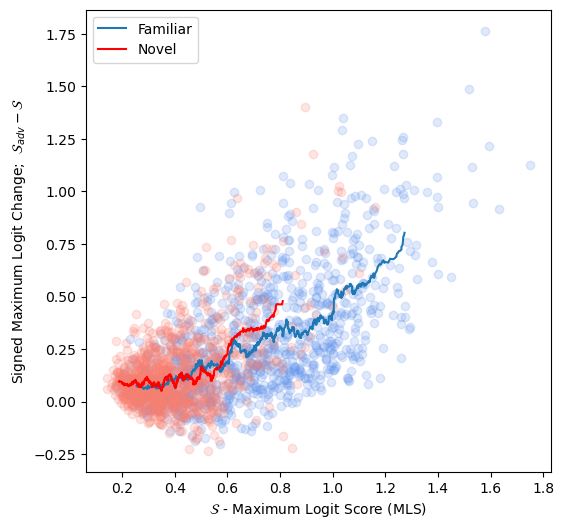

In [21]:
# scoring rool fn sum exp apendix
file_name = 'scoring_fn_sum_exp_'
file_name_list.append(file_name)
plot_diff_stats_for_eps(root_dir + "logits/tinyimagenet/plain/logits_0.pt",
                       root_dir + "logits/tinyimagenet/fn/fgsm/sum_exp/",
                       root_dir + "logits/tinyimagenet/plain/csr_targets_0.pt",
                       split_num = 0, 
                       dataset_name='tinyimagenet',
                       figsize=(10,4),
                       highlight_eps_idx=17,
                       save_path=vis_log + file_name + 'all_eps')

scatter_mls_diffs = IdOodPlot()
scatter_mls_diffs.load_mls_diffs_stats(root_dir + "logits/tinyimagenet/plain/logits_0.pt",
                                                root_dir + "logits/tinyimagenet/fn/fgsm/sum_exp/eps_0.0681/logits_0.pt",
                                                root_dir + "logits/tinyimagenet/plain/csr_targets_0.pt",
                                                0, dataset_name='tinyimagenet', balance=True)
scatter_mls_diffs.make_boxplot(labels = ['Familiar', 'Novel'], ylabel=r'Signed Maximum Logit Change;  $\mathcal{S}_{adv} - \mathcal{S}$')
scatter_mls_diffs.show_and_save(save_path=vis_log + file_name + 'box')
scatter_mls_diffs.make_scatter_plot(window_size=25, ylabel=r'Signed Maximum Logit Change;  $\mathcal{S}_{adv} - \mathcal{S}$')
scatter_mls_diffs.set_legend()
scatter_mls_diffs.show_and_save(save_path=vis_log + file_name + 'scatter')

### For all eps

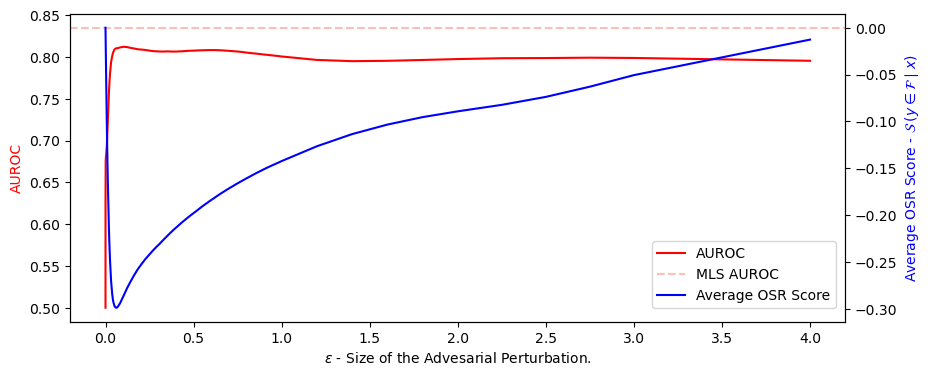

In [22]:
file_name = 'auroc_and_score_fp_two_norm'
file_name_list.append(file_name)
mlc_plot_fp_two_norm = EpsExperimentPlot(add_zoom=None)
mlc_plot_fp_two_norm.load_and_add_logit_change_to_eps_plot(tin_logits_dir + 'fp/fgsm/two_norm/', tin_logits_dir + 'plain/logits_0.pt', 0, invert_auroc=True)
mlc_plot_fp_two_norm.set_legend_and_highlight_eps(legend_loc=(0.70,0.18), h_line=0.835)
mlc_plot_fp_two_norm.show_and_save(save_path=vis_log + file_name)

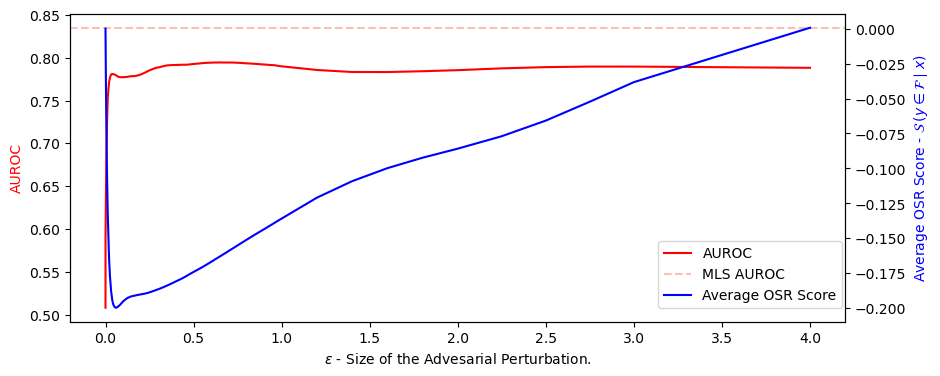

In [23]:
file_name = 'auroc_and_score_fp_max'
file_name_list.append(file_name)
mlc_plot_fp_max = EpsExperimentPlot(add_zoom=None)
mlc_plot_fp_max.load_and_add_logit_change_to_eps_plot(tin_logits_dir + 'fp/fgsm/max/', tin_logits_dir + 'plain/logits_0.pt', 0, invert_auroc=True)
mlc_plot_fp_max.set_legend_and_highlight_eps(legend_loc=(0.70,0.18), h_line=0.835)
mlc_plot_fp_max.show_and_save(save_path=vis_log + file_name)

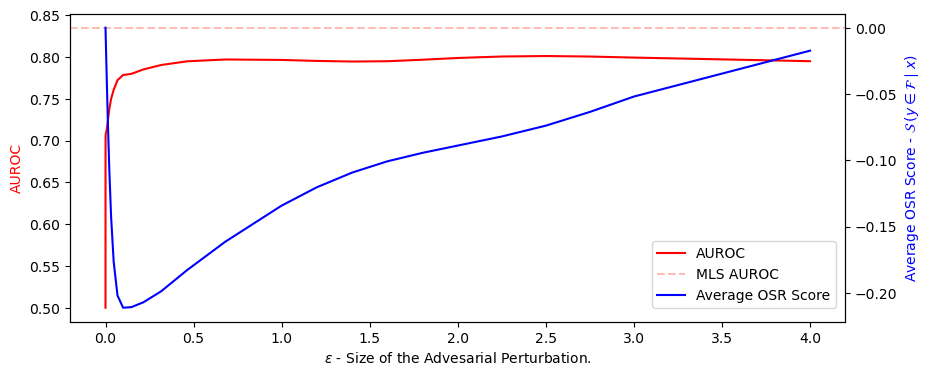

In [24]:
file_name = 'auroc_and_score_fp_sum_exp'
file_name_list.append(file_name)
mlc_plot_fp_sum_exp = EpsExperimentPlot(add_zoom=None)
mlc_plot_fp_sum_exp.load_and_add_logit_change_to_eps_plot(tin_logits_dir + 'fp/fgsm/sum_exp/', tin_logits_dir + 'plain/logits_0.pt', 0, invert_auroc=True)
mlc_plot_fp_sum_exp.set_legend_and_highlight_eps(legend_loc=(0.70,0.18), h_line=0.835)
mlc_plot_fp_sum_exp.show_and_save(save_path=vis_log + file_name)

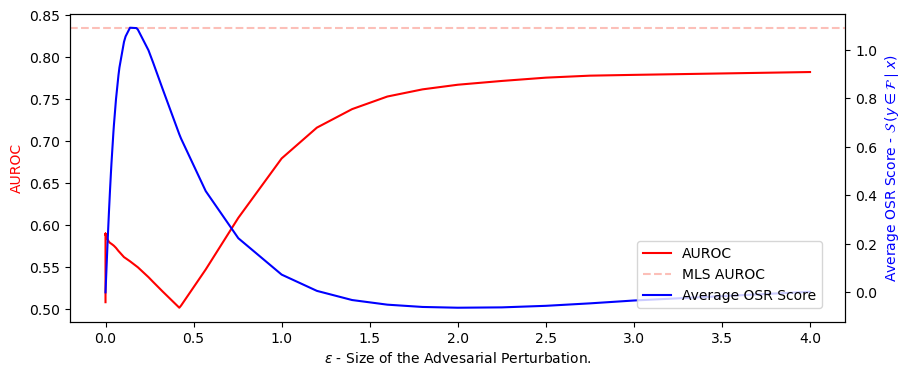

In [25]:
file_name = 'auroc_and_score_fn_max'
file_name_list.append(file_name)
mlc_plot_fn_max = EpsExperimentPlot(add_zoom=None)
mlc_plot_fn_max.load_and_add_logit_change_to_eps_plot(tin_logits_dir + 'fn/fgsm/max/', tin_logits_dir + 'plain/logits_0.pt', 0, invert_auroc=True)
mlc_plot_fn_max.set_legend_and_highlight_eps(legend_loc=(0.70,0.18), h_line=0.835)
mlc_plot_fn_max.show_and_save(save_path=vis_log + file_name)

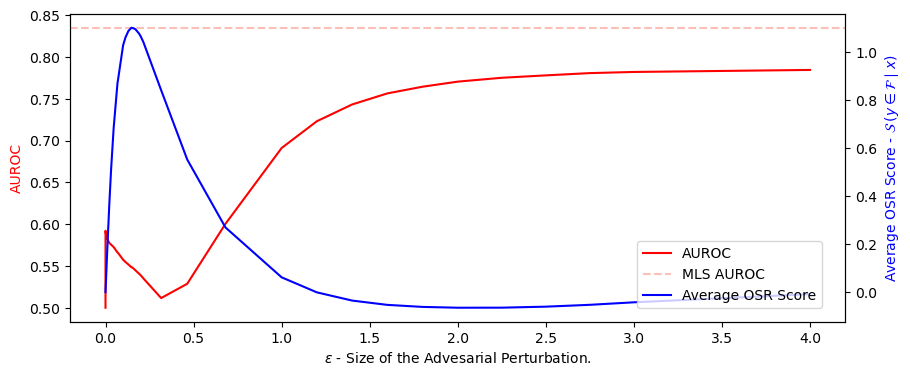

In [26]:
file_name = 'auroc_and_score_fn_log_msp'
file_name_list.append(file_name)
mlc_plot_fn_log_msp = EpsExperimentPlot(add_zoom=None)
mlc_plot_fn_log_msp.load_and_add_logit_change_to_eps_plot(tin_logits_dir + 'fn/fgsm/log_msp/', tin_logits_dir + 'plain/logits_0.pt', 0, invert_auroc=True)
mlc_plot_fn_log_msp.set_legend_and_highlight_eps(legend_loc=(0.70,0.18), h_line=0.835)
mlc_plot_fn_log_msp.show_and_save(save_path=vis_log + file_name)

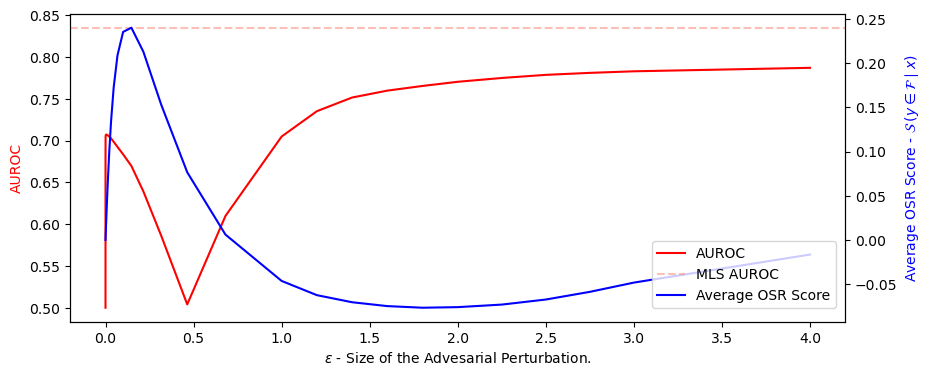

In [27]:
file_name = 'auroc_and_score_fn_sum_exp'
file_name_list.append(file_name)
mlc_plot_fn_sum_exp = EpsExperimentPlot(add_zoom=None)
mlc_plot_fn_sum_exp.load_and_add_logit_change_to_eps_plot(tin_logits_dir + 'fn/fgsm/sum_exp/', tin_logits_dir + 'plain/logits_0.pt', 0, invert_auroc=True)
mlc_plot_fn_sum_exp.set_legend_and_highlight_eps(legend_loc=(0.70,0.18), h_line=0.835)
mlc_plot_fn_sum_exp.show_and_save(save_path=vis_log + file_name)

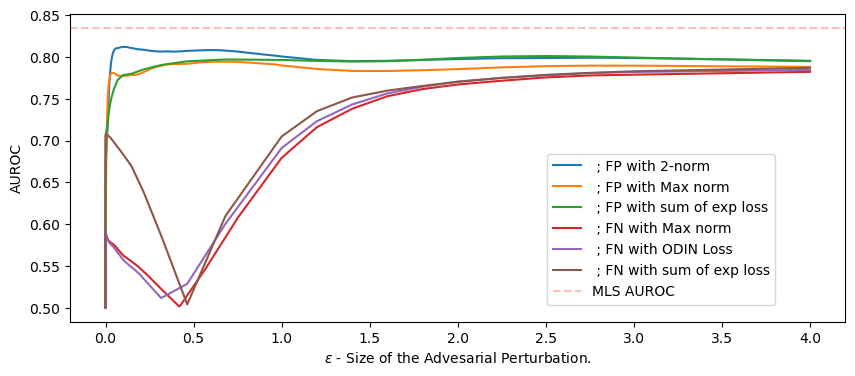

In [28]:
file_name = 'all_scoring_rools_auroc'
file_name_list.append(file_name)
auroc_comparison = EpsExperimentPlot(which_lines='AUROC', add_zoom=None)
auroc_comparison.load_and_add_logit_change_to_eps_plot(tin_logits_dir + 'fp/fgsm/two_norm/', tin_logits_dir + 'plain/logits_0.pt', 0, label_suffix=' ; FP with 2-norm', invert_auroc=True)
auroc_comparison.load_and_add_logit_change_to_eps_plot(tin_logits_dir + 'fp/fgsm/max/', tin_logits_dir + 'plain/logits_0.pt', 0, label_suffix= ' ; FP with Max norm', invert_auroc=True)
auroc_comparison.load_and_add_logit_change_to_eps_plot(tin_logits_dir + 'fp/fgsm/sum_exp/', tin_logits_dir + 'plain/logits_0.pt', 0, label_suffix= ' ; FP with sum of exp loss', invert_auroc=True)
auroc_comparison.load_and_add_logit_change_to_eps_plot(tin_logits_dir + 'fn/fgsm/max/', tin_logits_dir + 'plain/logits_0.pt', 0, label_suffix=' ; FN with Max norm', invert_auroc=True)
auroc_comparison.load_and_add_logit_change_to_eps_plot(tin_logits_dir + 'fn/fgsm/log_msp/', tin_logits_dir + 'plain/logits_0.pt', 0, label_suffix= ' ; FN with ODIN Loss', invert_auroc=True)
auroc_comparison.load_and_add_logit_change_to_eps_plot(tin_logits_dir + 'fn/fgsm/sum_exp/', tin_logits_dir + 'plain/logits_0.pt', 0, label_suffix= ' ; FN with sum of exp loss', invert_auroc=True)

auroc_comparison.set_legend_and_highlight_eps(legend_loc=(0.64,0.19), h_line=0.835)
auroc_comparison.show_and_save(save_path=vis_log + file_name)

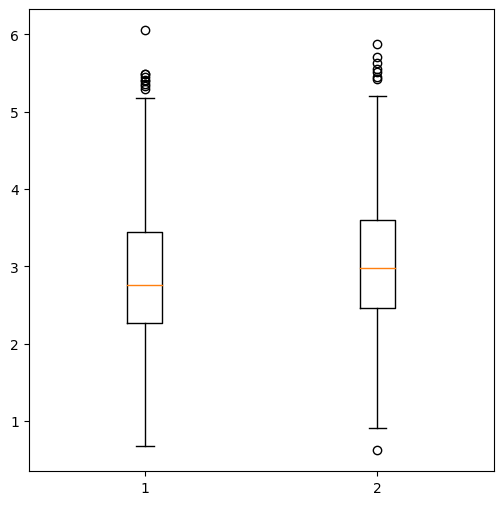

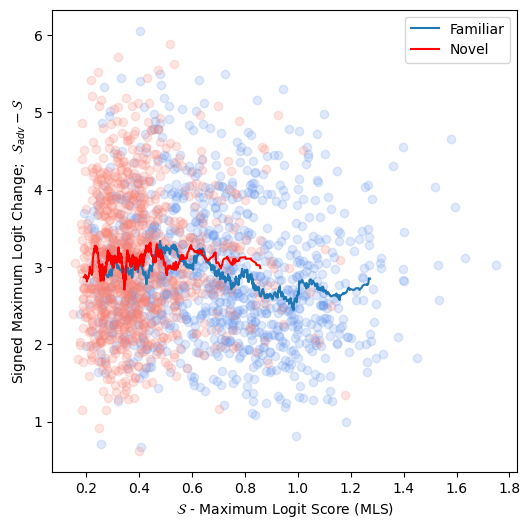

In [29]:
file_name = 'scoring_itat_fn_'
file_name_list.append(file_name)
scatter_mls_diffs = IdOodPlot()
scatter_mls_diffs.load_mls_diffs_stats(root_dir + "logits/tinyimagenet/plain/logits_0.pt",
                                                root_dir + "logits/tinyimagenet/fn/itat/max/eps_0.139/logits_0.pt",
                                                root_dir + "logits/tinyimagenet/fn/itat/max/eps_0.139/csr_targets_0.pt",
                                                0, dataset_name='tinyimagenet', balance=True)
scatter_mls_diffs.make_boxplot()
scatter_mls_diffs.show_and_save(save_path=vis_log + file_name + 'box')
scatter_mls_diffs.make_scatter_plot(window_size=25, ylabel=r'Signed Maximum Logit Change;  $\mathcal{S}_{adv} - \mathcal{S}$')
scatter_mls_diffs.set_legend()
scatter_mls_diffs.show_and_save(save_path=vis_log + file_name + 'scatter')

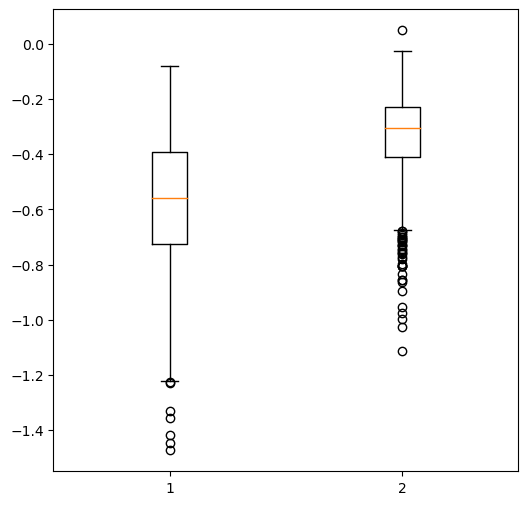

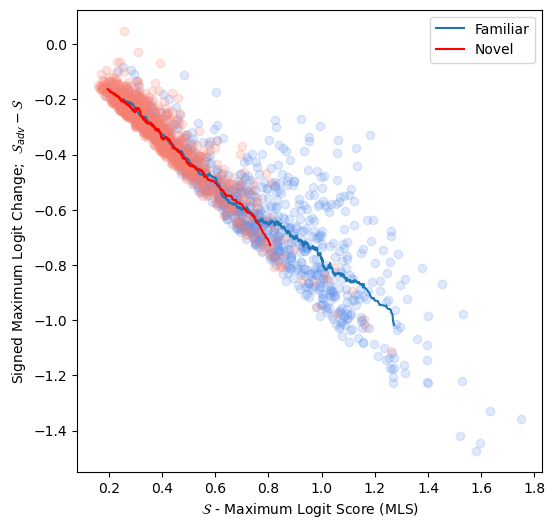

In [30]:
file_name = 'scoring_itat_fp_'
file_name_list.append(file_name)
scatter_mls_diffs = IdOodPlot()
scatter_mls_diffs.load_mls_diffs_stats(root_dir + "logits/tinyimagenet/plain/logits_0.pt",
                                                root_dir + "logits/tinyimagenet/fp/itat/two_norm/eps_0.0622/logits_0.pt",
                                                root_dir + "logits/tinyimagenet/fp/itat/two_norm/eps_0.0622/csr_targets_0.pt",
                                                0, dataset_name='tinyimagenet', balance=True)
scatter_mls_diffs.make_boxplot()
scatter_mls_diffs.show_and_save(save_path=vis_log + file_name + 'box')
scatter_mls_diffs.make_scatter_plot(window_size=25, ylabel=r'Signed Maximum Logit Change;  $\mathcal{S}_{adv} - \mathcal{S}$')
scatter_mls_diffs.set_legend()
scatter_mls_diffs.show_and_save(save_path=vis_log + file_name + 'scatter')

In [31]:
file_name_list

['mls_comp_fgsm_fp',
 'mls_comp_fgsm_fn',
 'auroc_comp_fgsm_fp',
 'auroc_comp_fgsm_fn',
 'vis_pertubation_fgsm_fp_',
 'vis_pertubation_fgsm_fn_',
 'fgsm_v_itat_fp_',
 'fgsm_v_itat_fn_',
 'roc_fgsm',
 'roc_itat',
 'ranking_plain',
 'ranking_both',
 'ranking_fp',
 'ranking_fn',
 'gradient_norm_',
 'scoring_fp_two_norm_',
 'scoring_fp_max_',
 'scoring_fn_two_norm_',
 'scoring_fn_sum_exp_',
 'auroc_and_score_fp_two_norm',
 'auroc_and_score_fp_max',
 'auroc_and_score_fp_sum_exp',
 'auroc_and_score_fn_max',
 'auroc_and_score_fn_log_msp',
 'auroc_and_score_fn_sum_exp',
 'all_scoring_rools_auroc',
 'scoring_itat_fn_',
 'scoring_itat_fp_']

In [32]:
for file_name in file_name_list:
    print("""\\begin{figure}[H]
    \centering
    \makebox[\\textwidth][c]
    {\includegraphics[width=1\linewidth]{images/experiments/"""+ file_name + """.pdf}}
    \caption{Caption}
    \label{fig:my_label}
\end{figure}""")

\begin{figure}[H]
    \centering
    \makebox[\textwidth][c]
    {\includegraphics[width=1\linewidth]{images/experiments/mls_comp_fgsm_fp.pdf}}
    \caption{Caption}
    \label{fig:my_label}
\end{figure}
\begin{figure}[H]
    \centering
    \makebox[\textwidth][c]
    {\includegraphics[width=1\linewidth]{images/experiments/mls_comp_fgsm_fn.pdf}}
    \caption{Caption}
    \label{fig:my_label}
\end{figure}
\begin{figure}[H]
    \centering
    \makebox[\textwidth][c]
    {\includegraphics[width=1\linewidth]{images/experiments/auroc_comp_fgsm_fp.pdf}}
    \caption{Caption}
    \label{fig:my_label}
\end{figure}
\begin{figure}[H]
    \centering
    \makebox[\textwidth][c]
    {\includegraphics[width=1\linewidth]{images/experiments/auroc_comp_fgsm_fn.pdf}}
    \caption{Caption}
    \label{fig:my_label}
\end{figure}
\begin{figure}[H]
    \centering
    \makebox[\textwidth][c]
    {\includegraphics[width=1\linewidth]{images/experiments/vis_pertubation_fgsm_fp_.pdf}}
    \caption{Caption}
    \l